In [105]:
import os
import torch
import torchvision

import h5py
import deepdish as dd

import cv2
import numpy as np

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision

import matplotlib.pyplot as plt
import matplotlib.patches as patches

from PIL import Image
from sklearn.metrics import roc_auc_score
from torchvision import models, transforms

import tempfile
import time
import pickle as pkl

In [2]:
model_file = 'data/saved_models/nodule_binary.pth'
img_path = 'data/sorted_images/Nodule/AP/00023068_003.png'

In [104]:
class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        
        self.model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=False)
        self.model.fc = nn.Sequential(*[
            nn.Linear(in_features=512, out_features=1, bias=True),
            nn.Sigmoid()
        ])
        
        self.features_conv = nn.Sequential(*list(self.model.children())[:-2])
        self.global_pool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.classifier =  nn.Sequential(*list(self.model.children())[-2:][1:])
        
        self.gradients = None
        
    def load_weights(self):
        self.model = torch.nn.DataParallel(self.model)
        self.model.load_state_dict(torch.load(model_file))
    
    def activations_hook(self, grad):
        self.gradients = grad
        
    def forward(self, x):
        x = self.features_conv(x)

        h = x.register_hook(self.activations_hook)

        x = self.global_pool(x)
        x = x.view(1, -1)    
        x = self.classifier(x)
        
        return x
    
    def get_activations_gradient(self):
        return self.gradients
    
    def get_activations(self, x):
        return self.features_conv(x)


In [64]:
model = ResNet()

Using cache found in /home/npp002/.cache/torch/hub/pytorch_vision_v0.6.0


In [65]:
model.load_weights()

In [66]:
transform = torchvision.transforms.ToTensor()

img = Image.open(img_path).convert('RGB')
img = transform(img)
img.shape
img = img.unsqueeze(dim=0)
img = img.cuda();

In [67]:
model = model.cuda()
model.eval()

pred = model(img)

In [116]:
print(pred)

tensor([[0.4492]], device='cuda:0', grad_fn=<SigmoidBackward>)


In [68]:
pred.backward()

In [71]:
gradients = model.get_activations_gradient()

In [72]:
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

In [76]:
activations = model.get_activations(img).detach()

In [77]:
activations.size()

torch.Size([1, 512, 32, 32])

In [78]:
for i in range(512):
    activations[:, i, :, :] *= pooled_gradients[i]

In [83]:
heatmap = torch.mean(activations, dim=1).squeeze()
heatmap = heatmap.cpu()

In [84]:
heatmap = np.maximum(heatmap, 0)

In [85]:
heatmap /= torch.max(heatmap)

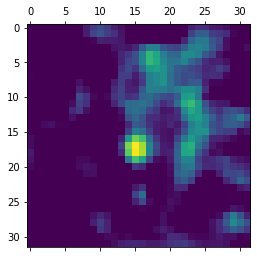

In [92]:
plt.matshow(heatmap)

In [108]:
import cv2
img = cv2.imread(img_path)
heatmap = cv2.resize(np.float32(heatmap), (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img
cv2.imwrite('./map.jpg', superimposed_img)

True

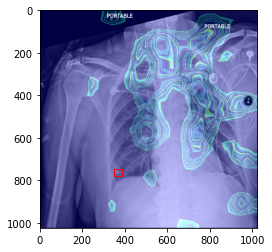

In [118]:
plt_image = cv2.imread('./map.jpg')
plt_image = cv2.cvtColor(plt_image, cv2.COLOR_BGR2RGB)
fig, ax = plt.subplots()
ax.imshow(plt_image)

x = 351.085714285714
y = 747.68253968254
width = 35.7587301587302
height = 33.5915343915344

rect = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)